In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load data
ego_alter_df = pd.read_csv('NetWorkSurvey.csv')  # Table 1
ego_df = pd.read_csv('BasicSurvey.csv')         # Table 2

# Create a graph
G = nx.Graph()

# Add all unique IDs from both tables to ensure no duplicates
all_ids = set(ego_df['egoid'])
all_alter_ids = set(ego_alter_df['alterid'])


health_mapping =  {
    'Poor':1,
    'Fair':2,
    'Good':3,
    'Excellent':4
}

health_dictionary = {}

# Add nodes with health attributes, ensuring values are numeric
for node_id in all_ids:
    ego_health = ego_df.loc[ego_df['egoid'] == node_id, 'Health_1']
    # Prefer health from ego table if available, otherwise use alter table
    health = ego_health.values[0] if not ego_health.empty else None

    # Convert health to numeric (default to None if conversion fails)
    try:
        health = health_mapping.get(health, None)
    except (ValueError, TypeError):
        health = None

    # Add node with numeric health attribute
    health_dictionary[node_id] = health
    G.add_node(node_id)

for node_id in all_alter_ids:
    alter_health = ego_alter_df.loc[ego_alter_df['alterid'] == node_id, 'althlth']
    health = alter_health.values[0] if not alter_health.empty else None
    try:
        health = health_mapping.get(health, None)
    except (ValueError, TypeError):
        health = None
    health_dictionary[node_id] = health
    G.add_node(node_id)



# Add edges with relationship attributes, ensuring numeric values for closeness
for _, row in ego_alter_df.iterrows():
    # Convert closeness to numeric using mapping
    closeness_mapping = {
        'Distant': 1,
        'LessThanClose': 2,
        'MerelyClose': 3,
        'EspeciallyClose': 4
    }
    closeness_numeric = closeness_mapping.get(row['close'], 1)  # Default to 1 if not found

    # Add edges only for true friends
    if row['friend']:
        G.add_edge(
            row['egoid'], row['alterid'],
            closeness_numeric=closeness_numeric,
            friend=row['friend']
        )


C:\Users\theroot\AppData\Local\Temp\ipykernel_26176\2289418391.py:6: DtypeWarning: Columns (14,15,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  ego_alter_df = pd.read_csv('NetWorkSurvey.csv')  # Table 1
C:\Users\theroot\AppData\Local\Temp\ipykernel_26176\2289418391.py:7: DtypeWarning: Columns (314,391,392,789,791,792,1124,1125,1227,1228,1231,1232,1477,1478,1554,1555,1556,1557,1558,1559,1561,1568,1571,1678,1687,1745,1746,1818,1836,1837,1843,1844,1849,1851,1852,1853,2072,2116,2117,2264,2266,2280,2281,2282,2283,2289,2290,2483,2484,2501,2502,2508,2509,2699,2711,2712,2830) have mixed types. Specify dtype option on import or set low_memory=False.
  ego_df = pd.read_csv('BasicSurvey.csv')         # Table 2


In [8]:
import math

ego_health_analysis = []

# Loop over all nodes to compute weighted average health
for ego in G.nodes:
    # Get neighbors (friends) of the ego
    if len(str(ego)) > 5:
        continue
    friends = [
        n for n in G.neighbors(ego) 
        if n in health_dictionary 
    ]
    
    if friends:
        weighted_sum = 0
        total_weight = 0

        for friend in friends:
            # Ensure both node and edge attributes exist
            if friend in health_dictionary and 'closeness_numeric' in G.edges[ego, friend]:
                health = health_dictionary[friend]
                closeness = G.edges[ego, friend]['closeness_numeric']

                # Validate and convert to numeric
                if health is not None and closeness is not None:
                    weighted_sum += health * closeness
                    total_weight += closeness

        # Avoid division by zero
        weighted_avg_health = weighted_sum / total_weight if total_weight > 0 else None
    else:
        weighted_avg_health = None

    # Ensure 'health' exists for the ego node before accessing it
    ego_health = health_dictionary.get(ego, None)

    ego_health_analysis.append({
        'node_id': ego,
        'health': ego_health,
        'weighted_avg_friends_health': weighted_avg_health
    })

# Convert results to a DataFrame for analysis
health_df = pd.DataFrame(ego_health_analysis).dropna()
print(health_df)


     node_id  health  weighted_avg_friends_health
0      38914     4.0                     4.000000
3      81930     4.0                     3.000000
12     79897     4.0                     4.000000
34     43125     3.0                     4.000000
43     28824     2.0                     3.000000
47     98462     4.0                     3.545455
71     35031     4.0                     3.789474
75     26857     4.0                     2.000000
102    51495     4.0                     3.727273
111    22842     3.0                     3.000000
122    67918     2.0                     4.000000
125    49497     2.0                     3.363636
166    94662     4.0                     3.750000
169    98760     4.0                     4.000000
179    33239     3.0                     3.769231
184    10732     4.0                     4.000000
208    37404     3.0                     3.000000
228    29257     4.0                     3.025641
287    56058     4.0                     3.941176


Pearson Correlation: -0.04, p-value: 8.05e-01


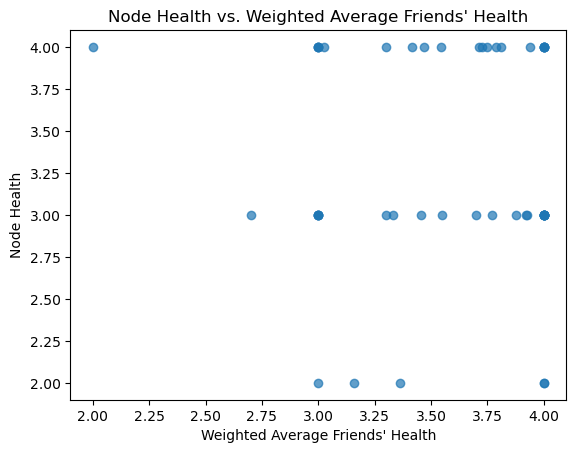

In [9]:
from scipy.stats import pearsonr

# Drop rows with missing data
health_df_cleaned = health_df.dropna()

# Correlation analysis
if not health_df_cleaned.empty:
    correlation, p_value = pearsonr(
        health_df_cleaned['health'],
        health_df_cleaned['weighted_avg_friends_health']
    )
    print(f"Pearson Correlation: {correlation:.2f}, p-value: {p_value:.2e}")

    # Plot the relationship
    plt.scatter(
        health_df_cleaned['weighted_avg_friends_health'],
        health_df_cleaned['health'],
        alpha=0.7
    )
    plt.title("Node Health vs. Weighted Average Friends' Health")
    plt.xlabel("Weighted Average Friends' Health")
    plt.ylabel("Node Health")
    plt.show()
else:
    print("No valid data for correlation analysis.")


In [16]:
import math

ego_health_analysis_unweighted = []

# Loop over all nodes to compute unweighted average health
for ego in G.nodes:
    # Get neighbors (friends) of the ego
    friends = [
        n for n in G.neighbors(ego)
        if n in health_dictionary
    ]

    if friends:
        # Compute unweighted sum of friends' health
        total_health = 0 
        num_friends = 0
        for friend in friends:
            friend_health = health_dictionary.get(friend, -1)
            if friend_health is not None and friend_health != -1:
                total_health += friend_health
                num_friends +=1 
        if num_friends >0:
            unweighted_avg_health = total_health / num_friends
        else:
            unweighted_avg_health = None
    else:
        unweighted_avg_health = None

    # Ensure 'health' exists for the ego node before accessing it
    ego_health = health_dictionary.get(ego, None)

    # Append the result
    ego_health_analysis_unweighted.append({
        'node_id': ego,
        'health': ego_health,
        'unweighted_avg_friends_health': unweighted_avg_health
    })

# Convert results to a DataFrame for analysis
health_df_unweighted = pd.DataFrame(ego_health_analysis_unweighted).dropna()
print(health_df_unweighted)


       node_id  health  unweighted_avg_friends_health
0        38914     4.0                            4.0
3        81930     4.0                            3.0
12       79897     4.0                            4.0
34       43125     3.0                            4.0
43       28824     2.0                            3.0
...        ...     ...                            ...
15609   327243     4.0                            3.0
15624   622190     4.0                            3.0
15667   229061     3.0                            4.0
15685   360162     4.0                            3.0
15811   950227     4.0                            4.0

[320 rows x 3 columns]


Pearson Correlation (Unweighted): -0.06, p-value: 2.68e-01


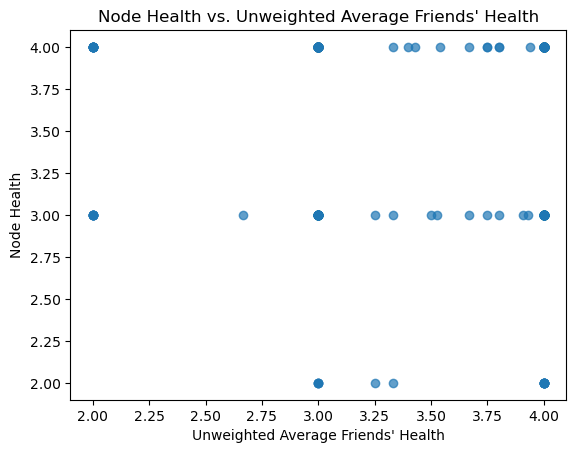

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Drop rows with missing data
health_df_unweighted_cleaned = health_df_unweighted.dropna()

# Correlation analysis
if not health_df_unweighted_cleaned.empty:
    correlation, p_value = pearsonr(
        health_df_unweighted_cleaned['health'],
        health_df_unweighted_cleaned['unweighted_avg_friends_health']
    )
    print(f"Pearson Correlation (Unweighted): {correlation:.2f}, p-value: {p_value:.2e}")

    # Scatterplot
    plt.scatter(
        health_df_unweighted_cleaned['unweighted_avg_friends_health'],
        health_df_unweighted_cleaned['health'],
        alpha=0.7
    )
    plt.title("Node Health vs. Unweighted Average Friends' Health")
    plt.xlabel("Unweighted Average Friends' Health")
    plt.ylabel("Node Health")
    plt.show()
else:
    print("No valid data for correlation analysis.")


Part 2: FitBit

In [4]:
import pandas as pd
fitbit_data = pd.read_csv('FitbitActivity.csv')
fitbit_data.dropna(subset=['steps', 'lowrangemins', 'fatburnmins', 'cardiomins', 'peakmins', 'sedentaryminutes', 'lightlyactiveminutes', 'fairlyactiveminutes', 'veryactiveminutes'])
# Group by 'egoid' and calculate the average for the specified columns
averages = fitbit_data.groupby('egoid').agg({
    'steps': 'mean',                 # Average steps
    'meanrate': 'mean',              # Average heart rate
    'sedentaryminutes': 'mean',      # Average sedentary minutes
    'lightlyactiveminutes': 'mean',  # Average lightly active minutes
    'fairlyactiveminutes': 'mean',   # Average fairly active minutes
    'veryactiveminutes': 'mean',     # Average very active minutes
    'lowrangemins': 'mean',          # Average low-range minutes
    'fatburnmins': 'mean',           # Average fat-burn minutes
    'cardiomins': 'mean',            # Average cardio minutes
    'peakmins': 'mean'               # Average peak minutes
}).reset_index()

# Rename columns for clarity
averages.rename(columns={
    'steps': 'average_steps',
    'meanrate': 'average_heart_rate',
    'sedentaryminutes': 'average_sedentary_minutes',
    'lightlyactiveminutes': 'average_lightly_active_minutes',
    'fairlyactiveminutes': 'average_fairly_active_minutes',
    'veryactiveminutes': 'average_very_active_minutes',
    'lowrangemins': 'average_low_range_minutes',
    'fatburnmins': 'average_fat_burn_minutes',
    'cardiomins': 'average_cardio_minutes',
    'peakmins': 'average_peak_minutes'
}, inplace=True)

# Save or display the result
print(averages.head())  # Display the result

   egoid  average_steps  average_heart_rate  average_sedentary_minutes  \
0  10237   12415.061093           75.225984                 650.421858   
1  10469    7885.719136           89.279848                1003.060606   
2  10547   16509.214286           77.981580                 753.428571   
3  11002   13308.022145           78.571042                 711.407143   
4  11128    9121.991404           76.240607                 828.231928   

   average_lightly_active_minutes  average_fairly_active_minutes  \
0                      244.457923                      47.045016   
1                      189.521212                       8.757576   
2                      226.750000                      52.714286   
3                      230.586905                      52.179487   
4                      166.234940                      16.071429   

   average_very_active_minutes  average_low_range_minutes  \
0                    47.510383                1093.278671   
1                     4.

In [9]:
egoids_set = set(averages['egoid'])

# Initialize a dictionary to store ego and friends' comparisons
ego_friend_comparisons = []

# Analyze each ego in the graph G
for ego in G.nodes:
    if ego in egoids_set:
        # Get neighbors (friends) of the ego
        friends = [n for n in G.neighbors(ego) if n in egoids_set]
        
        if friends:
            # Get ego's metrics
            ego_metrics = averages[averages['egoid'] == ego].iloc[0]
            
            # Calculate the average metrics of friends
            friend_metrics = averages[averages['egoid'].isin(friends)].mean()
            
            # Compare ego's metrics with their friends' average metrics
            comparison = {
                'egoid': ego,
                'ego_steps': ego_metrics['average_steps'],
                'friends_average_steps': friend_metrics['average_steps'],
                'ego_heart_rate': ego_metrics['average_heart_rate'],
                'friends_average_heart_rate': friend_metrics['average_heart_rate'],
                'ego_sedentary_minutes': ego_metrics['average_sedentary_minutes'],
                'friends_average_sedentary_minutes': friend_metrics['average_sedentary_minutes'],
                'ego_lightly_active_minutes': ego_metrics['average_lightly_active_minutes'],
                'friends_average_lightly_active_minutes': friend_metrics['average_lightly_active_minutes']
            }
            # Add more metrics as needed
            
            # Append the comparison to the list
            ego_friend_comparisons.append(comparison)

# Convert the comparisons into a DataFrame
comparisons_df = pd.DataFrame(ego_friend_comparisons)

# Save or display the comparison results
# comparisons_df.to_csv('ego_friend_comparisons.csv', index=False)
print(comparisons_df.head())

   egoid     ego_steps  friends_average_steps  ego_heart_rate  \
0  38914   7882.108108            9514.286890       73.600837   
1  94215  14102.944954           11792.671197       73.622217   
2  28681   8666.666667           12413.296173       70.993846   
3  36875  12593.385686           11059.220287       83.876447   
4  22540   5666.837061            9444.381022       87.197786   

   friends_average_heart_rate  ego_sedentary_minutes  \
0                   74.837370            1102.693333   
1                   78.002269            1038.864717   
2                   73.248536             752.416667   
3                   73.202552             846.900596   
4                   75.100267             800.559105   

   friends_average_sedentary_minutes  ego_lightly_active_minutes  \
0                         943.559635                  111.453333   
1                         777.661015                  170.542962   
2                         740.958428                  265.500000   


Correlation: Analyze the relationship between ego metrics and their friends' average metrics using Pearson or Spearman correlations.



In [ ]:
from scipy.stats import pearsonr, spearmanr

# Correlation between ego and friends' steps
step_corr, step_pval = pearsonr(comparisons_df['ego_steps'], comparisons_df['friends_average_steps'])
print(f"Pearson Correlation (Steps): {step_corr:.2f}, p-value: {step_pval:.4f}")

# Correlation between ego and friends' heart rate
heart_rate_corr, heart_rate_pval = pearsonr(comparisons_df['ego_heart_rate'], comparisons_df['friends_average_heart_rate'])
print(f"Pearson Correlation (Heart Rate): {heart_rate_corr:.2f}, p-value: {heart_rate_pval:.4f}")

# Additional metrics
for metric in ['ego_sedentary_minutes', 'ego_lightly_active_minutes']:
    friends_metric = metric.replace('ego_', 'friends_average_')
    corr, pval = pearsonr(comparisons_df[metric], comparisons_df[friends_metric])
    print(f"Pearson Correlation ({metric} vs. {friends_metric}): {corr:.2f}, p-value: {pval:.4f}")


Pearson Correlation (Steps): 0.16, p-value: 0.0001
Spearman Correlation (Heart Rate): 0.21, p-value: 0.0000
Pearson Correlation (ego_sedentary_minutes vs. friends_average_sedentary_minutes): 0.09, p-value: 0.0204
Pearson Correlation (ego_lightly_active_minutes vs. friends_average_lightly_active_minutes): 0.07, p-value: 0.0743


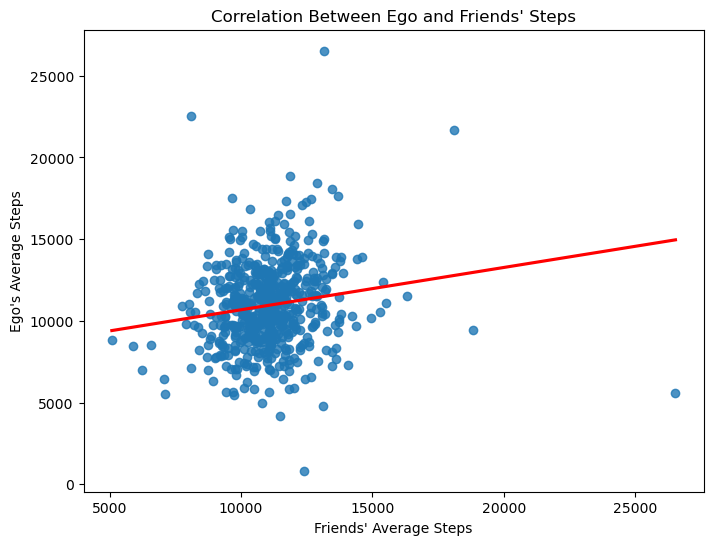

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Scatter plot for ego steps vs. friends' average steps
plt.figure(figsize=(8, 6))
sns.regplot(x='friends_average_steps', y='ego_steps', data=comparisons_df, ci=None, line_kws={'color': 'red'})
plt.xlabel("Friends' Average Steps")
plt.ylabel("Ego's Average Steps")
plt.title("Correlation Between Ego and Friends' Steps")
plt.show()


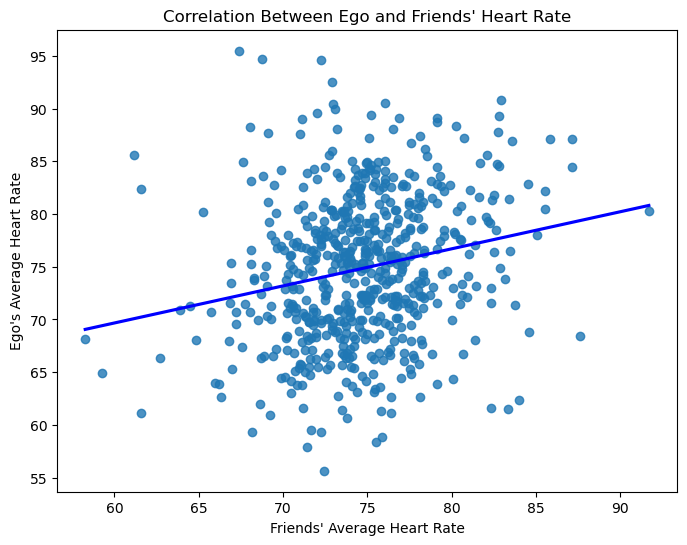

In [14]:
# Scatter plot for ego heart rate vs. friends' average heart rate
plt.figure(figsize=(8, 6))
sns.regplot(x='friends_average_heart_rate', y='ego_heart_rate', data=comparisons_df, ci=None, line_kws={'color': 'blue'})
plt.xlabel("Friends' Average Heart Rate")
plt.ylabel("Ego's Average Heart Rate")
plt.title("Correlation Between Ego and Friends' Heart Rate")
plt.show()

c:\Users\theroot\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


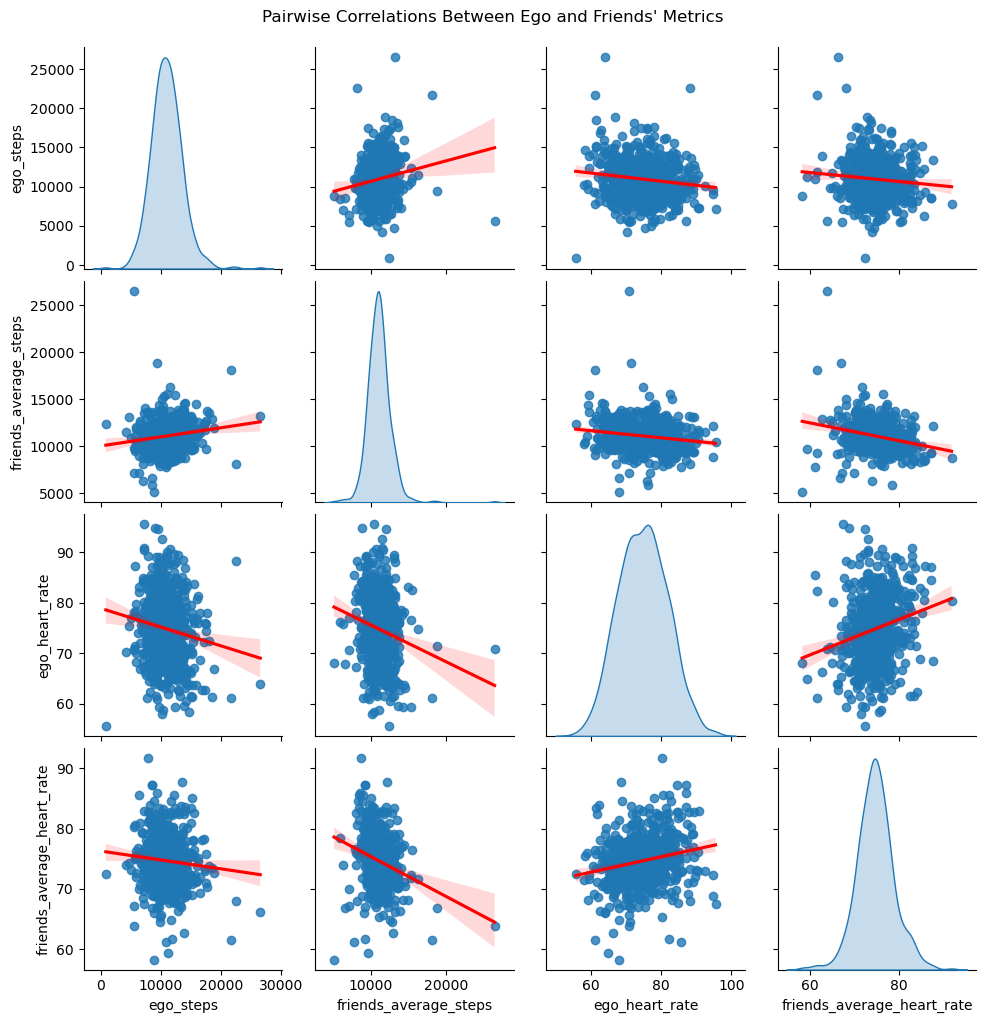

In [15]:
# Pair plot for steps and heart rate metrics
sns.pairplot(
    comparisons_df[['ego_steps', 'friends_average_steps', 'ego_heart_rate', 'friends_average_heart_rate']],
    kind='reg',
    diag_kind='kde',
    plot_kws={'line_kws': {'color': 'red'}}
)
plt.suptitle("Pairwise Correlations Between Ego and Friends' Metrics", y=1.02)
plt.show()

Use regression models to quantify the influence of friends' metrics on ego metrics while controlling for confounding factors.

In [11]:
import statsmodels.api as sm

# Define the independent variables (friends' metrics)
X = comparisons_df[['friends_average_steps', 'friends_average_heart_rate']]
X = sm.add_constant(X)  # Add constant for the regression

# Define the dependent variable (ego's steps)
y = comparisons_df['ego_steps']

# Fit the regression model
model = sm.OLS(y, X).fit()
print(model.summary())

# Repeat for heart rate
X_heart = comparisons_df[['friends_average_steps', 'friends_average_heart_rate']]
X_heart = sm.add_constant(X_heart)
y_heart = comparisons_df['ego_heart_rate']
model_heart = sm.OLS(y_heart, X_heart).fit()
print(model_heart.summary())


                            OLS Regression Results                            
Dep. Variable:              ego_steps   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     8.622
Date:                Wed, 20 Nov 2024   Prob (F-statistic):           0.000203
Time:                        20:28:58   Log-Likelihood:                -5585.4
No. Observations:                 603   AIC:                         1.118e+04
Df Residuals:                     600   BIC:                         1.119e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

Group egos based on similarities in metrics (both their own and their friends') to identify patterns in behavior.


c:\Users\theroot\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\theroot\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\theroot\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\theroot\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when t

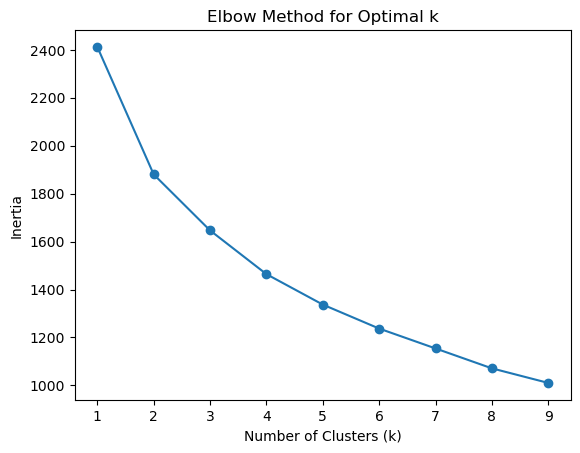

c:\Users\theroot\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\theroot\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


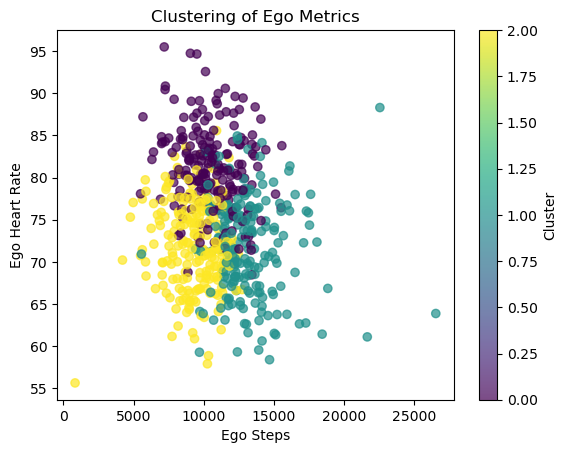

In [13]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Select metrics for clustering (combine ego and friends' metrics)
clustering_data = comparisons_df[['ego_steps', 'ego_heart_rate', 'friends_average_steps', 'friends_average_heart_rate']]

# Standardize the data
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)

# Determine optimal number of clusters using Elbow Method
inertia = []
k_values = range(1, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(clustering_data_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# Fit KMeans with optimal k (assume 3 from Elbow Method)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(clustering_data_scaled)

# Add cluster labels to DataFrame
comparisons_df['cluster'] = clusters

# Visualize clusters (2D projection using steps and heart rate)
plt.scatter(comparisons_df['ego_steps'], comparisons_df['ego_heart_rate'], c=comparisons_df['cluster'], cmap='viridis', alpha=0.7)
plt.xlabel('Ego Steps')
plt.ylabel('Ego Heart Rate')
plt.title('Clustering of Ego Metrics')
plt.colorbar(label='Cluster')
plt.show()
